The goal is to train a machine learning model to perform sentiment analysis on Tripadvisor reviews (data from https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews). 
A review with 4 or 5 stars is considered positive, 3 stars means neutral and 1 or 2 stars is considered negative.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import nltk

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf

In [2]:
df = pd.read_csv("tripadvisor_hotel_reviews.csv")

In [3]:
df.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


In [4]:
df.shape

(20491, 2)

In [5]:
df['Sentiment'] = np.select([df['Rating'] > 3, df['Rating'] == 3], [2, 1], 0) #if at least 4/5 -> positive Sentiment, 3 neutral, 1 or 2 -> negative

In [6]:
df.Sentiment.head(10)

0    2
1    0
2    1
3    2
4    2
5    2
6    2
7    2
8    2
9    2
Name: Sentiment, dtype: int32

In [7]:
df.value_counts(["Sentiment"])

Sentiment
2            15093
0             3214
1             2184
dtype: int64

Most (approx. 75%) of the reviews are positive (Sentiment = 2), only a small fraction (approx. 10%) is neutral (Sentiment = 1) and a bit more (approx. 15%) are negative (Sentiment = 0).

Lets set the review text to lowercase and split the data into a training set and validation set

In [8]:
df['Review'] = (df['Review']).str.lower()

In [9]:
train, val = train_test_split(df, test_size=0.2, random_state=5, stratify = df["Sentiment"])

In [10]:
train.describe()

,Rating,Sentiment
count,16392.000000,16392.000000
mean,3.955832,1.579734
std,1.233766,0.746570
min,1.000000,0.000000
25%,3.000000,1.000000
50%,4.000000,2.000000
75%,5.000000,2.000000
max,5.000000,2.000000


Lets create a feature that counts the length of a review

In [11]:
def leng(col):
    l=[]
    for rew in col:
        text = word_tokenize(rew, language='english')
        nonPunct = re.compile('.*[A-Za-z0-9].*')  # must contain a letter or digit
        filtered = [w for w in text if nonPunct.match(w)]
        l.append(len(filtered))
    return l

In [12]:
train['wordCount'] = leng(train['Review'])

#calculate mean and std to rescale the word count to be centered around 0
wrdcm = train['wordCount'].mean()
wrdcs = train['wordCount'].std()

train['scaledwordCount'] = (train['wordCount']-wrdcm)/wrdcs

val['wordCount'] = leng(val['Review'])
                      
val['scaledwordCount'] = (val['wordCount']-wrdcm)/wrdcs

In [13]:
wrdcm

103.66087115666178

In [14]:
train.head()

,Review,Rating,Sentiment,wordCount,scaledwordCount
14048,best boutique hotel room loved arcotel velvet ...,5,2,110,0.062802
3022,good value inclusive stayed melia tropical wee...,3,1,607,4.986583
14060,"exceptional hotel, gorgeous hotel quiet area e...",5,2,48,-0.551432
16302,"let-down, elizabeth proved complete opposite s...",1,0,28,-0.749573
1603,ok expecting money spent 3 nights chancellor h...,3,1,46,-0.571246


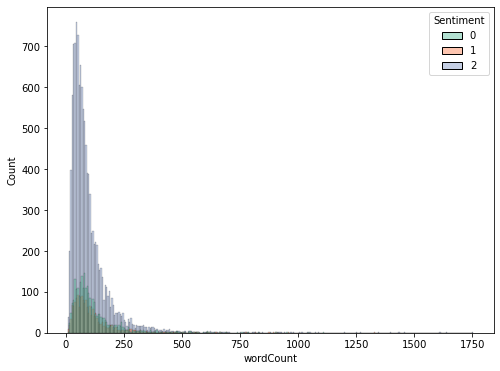

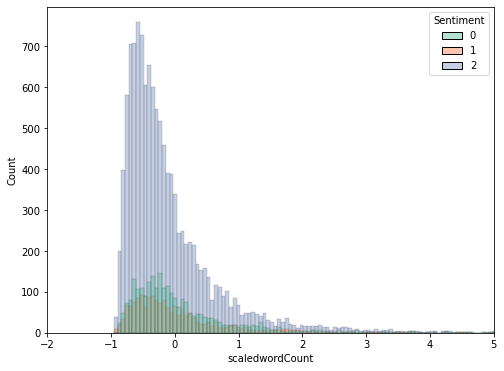

In [15]:
plt.figure(figsize=(8,6))
sns.histplot(data=train, x="wordCount", hue="Sentiment", alpha=0.5, palette="Set2")
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(data=train, x="scaledwordCount", hue="Sentiment", alpha=0.5, palette="Set2")

plt.xlim(-2,5)

plt.show()

Next extract features from the text. This will be done with a Term Frequency Inverse Document Frequency (Tfidf) vectorizer. We include a custom stopword list which includes word which will be ignored. max_df and min_df are maximal and minimal percentage of reviews in which a word has to be mention to be included. ngram_range controls whether the vectorizer should take phrases consisting of more than 1 word (e.g. 2 words appearing after each other or 3 words).

In [16]:
stpwrdlist=['the', 'a']#,'i','a','for','in']
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.005, stop_words=stpwrdlist, ngram_range=(1,3)) #stop_words=stpwrdlist

In [17]:
#fit and transform the reviews

X = vectorizer.fit_transform(train['Review']) 
X_val = vectorizer.transform(val['Review'])

In [18]:
#vectorizer.get_feature_names(); #to see the list of words

Lets fit a LogisticRegression model

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy import sparse


lr = LogisticRegression(multi_class="multinomial")

labels = ["negative", "neutral", "positive"]

Combine the vectorized texts in X and X_val with scaledwordCount to create final feature matrices

In [20]:
X = sparse.hstack((X,np.array(train['scaledwordCount'])[:,None])).A

X_val = sparse.hstack((X_val,np.array(val['scaledwordCount'])[:,None])).A

In [21]:
X.shape

(16392, 3385)

Fit and check accuracy of LogisticRegression

In [22]:
lr.fit(X, train['Sentiment'])#np.array(train['wordCount']).reshape(-1, 1), train['Sentiment'])

LogisticRegression(multi_class='multinomial')

In [23]:
preds = lr.predict(X)#np.array(train['wordCount']).reshape(-1,1))
score = accuracy_score(train['Sentiment'], preds)
print(score)

0.9018423621278673


In [24]:
preds1 = lr.predict(X_val)#np.array(test['wordCount']).reshape(-1,1))#X_val)
score = accuracy_score(val['Sentiment'], preds1)
print(score)

0.8665528177604294


The accuracy seems reasonable, lets check the confusion matrix

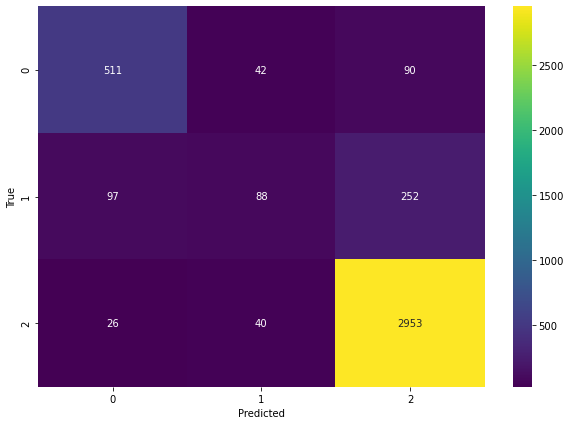

In [25]:
from sklearn.metrics import confusion_matrix



cm = confusion_matrix(val["Sentiment"], preds1)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap="viridis",fmt='g')
plt.ylabel("True")
plt.xlabel("Predicted")

plt.show()

This model struggels mostly with identifying neutral reviews, which is a result of the distribution of labels which mostly included positive reviews. Lets see if we can train a better model.

Lets train a neural network

In [26]:
#import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [27]:
model = Sequential()

early_stopping_monitor = EarlyStopping(patience=1)

model.add(Dense(64, input_shape=(3385,)))
model.add(Dense(128, activation="tanh"))
model.add(Dense(128, activation="tanh"))
model.add(Dense(64, activation="tanh"))

model.add(Dense(3, activation='softmax'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                216704    
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 249,987
Trainable params: 249,987
Non-trainable params: 0
_________________________________________________________________


In [29]:
opt = tf.keras.optimizers.Adam(0.0001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
h_callback = model.fit(X, pd.get_dummies(train['Sentiment']), validation_split=0.1, epochs=12, batch_size=48,callbacks=[early_stopping_monitor])
#validation_data=(X_val, test['Sentiment'])

Epoch 1/12
308/308 [==============================] - 3s 7ms/step - loss: 0.6162 - accuracy: 0.7730 - val_loss: 0.3951 - val_accuracy: 0.8500
Epoch 2/12
308/308 [==============================] - 2s 6ms/step - loss: 0.3424 - accuracy: 0.8631 - val_loss: 0.3627 - val_accuracy: 0.8579
Epoch 3/12
308/308 [==============================] - 2s 5ms/step - loss: 0.2920 - accuracy: 0.8830 - val_loss: 0.3605 - val_accuracy: 0.8573
Epoch 4/12
308/308 [==============================] - 2s 6ms/step - loss: 0.2545 - accuracy: 0.8991 - val_loss: 0.3730 - val_accuracy: 0.8567


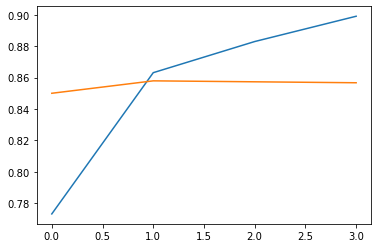

In [31]:
plt.plot( h_callback.history['accuracy'])
plt.plot( h_callback.history['val_accuracy'])
plt.show()

In [32]:
predictions = []
predictions1 = model.predict(X_val)

for i in range(len(X_val)): #.ravel()
    predictions.append(np.argmax(predictions1[i]))

In [33]:
score = model.evaluate(X_val, pd.get_dummies(val['Sentiment']), verbose=0)
print(score) #loss, accuracy

[0.3695077896118164, 0.856550395488739]


On first sight, this model has a slightly lower accuracy than the LogisticRegression model. Lets check its confusion matrix

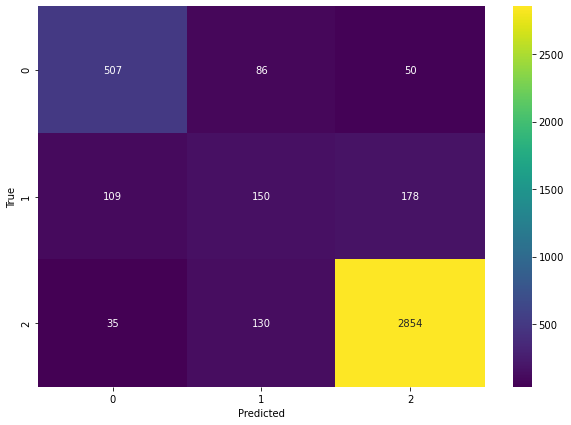

In [34]:
from sklearn.metrics import confusion_matrix



cm = confusion_matrix(val["Sentiment"], predictions)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap="viridis",fmt='g')
plt.ylabel("True")
plt.xlabel("Predicted")

plt.show()

Compared to the LogisticRegression model, the neural network is slightly more accurate at identifying neutral and negative reviews, but a bit less accurate in finding positive reviews.

Therefore, the Logitic Regression model should be better to use on reviews with similiar distribution of reviews as the training data. However if one needs to classify reviews which include more neutral and negative reviews than the neural network should perform better.

Lets write a function that classifies custom reviews:

In [35]:
def lrpredict(rev):
    testrew = vectorizer.transform(rev)
    testrew = sparse.hstack((testrew,np.array([len(rev)])[:,None])).A
    print("LogisticRegression predicts: " , labels[lr.predict(testrew)[0]])
    print(lr.predict_proba(testrew))
    return None

def nnpredict(rev):
    testrew = vectorizer.transform(rev)
    testrew = sparse.hstack((testrew,np.array([len(rev)])[:,None])).A
    print("Neural Network predicts: " , labels[np.argmax([model.predict(testrew)])])
    print(model.predict(testrew))
    return None

In [36]:
custom = ["mediocre food, high price, excellent location", "never again", "not great not terrible", "excellent location, but high price", "can recommend, tasty food and fair price"]

for review in custom:
    
    txt=[review]

    lrpredict(txt)

    nnpredict(txt)
    print("-----------------")
    print("-----------------")

LogisticRegression predicts:  positive
[[0.15099604 0.30409005 0.54491391]]
Neural Network predicts:  negative
[[0.5717116  0.3837296  0.04455884]]
-----------------
-----------------
LogisticRegression predicts:  positive
[[0.42477037 0.09160071 0.48362892]]
Neural Network predicts:  negative
[[0.7418406  0.23291059 0.02524882]]
-----------------
-----------------
LogisticRegression predicts:  negative
[[0.93168788 0.04408669 0.02422544]]
Neural Network predicts:  negative
[[9.656835e-01 3.423154e-02 8.496272e-05]]
-----------------
-----------------
LogisticRegression predicts:  positive
[[0.02750492 0.14821892 0.82427616]]
Neural Network predicts:  positive
[[0.05291415 0.3357026  0.6113833 ]]
-----------------
-----------------
LogisticRegression predicts:  positive
[[0.1516961  0.11713382 0.73117008]]
Neural Network predicts:  neutral
[[0.15969743 0.4904921  0.34981054]]
-----------------
-----------------


To improve the results a pretrained model (Bert) could be used